In [1]:
import h5py
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from astropy.visualization import ImageNormalize, LogStretch, SqrtStretch
from matplotlib.colors import LogNorm, SymLogNorm, Normalize
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import make_axes_locatable
from glob import glob
from tqdm import tqdm
from scipy.stats import chi2

plt.style.use("science") # requires SciencePlots
params = {'legend.fontsize': 27,
          'figure.figsize': (4, 4),
         'axes.labelsize': 27,
         'axes.titlesize': 30,
         'xtick.labelsize':30,
         'ytick.labelsize':30,
         'figure.titlesize': 40,
          'xtick.major.size': 8,
          'xtick.minor.size': 4,
         'xtick.major.width': 1,
          'xtick.minor.width': 1,
         'ytick.major.size': 8,
          'ytick.minor.size': 4,
         'ytick.major.width': 1,
          'ytick.minor.width': 1,

         }
pylab.rcParams.update(params)

nu = 128**2  # degrees of freedom

In [2]:
hf = h5py.File(os.path.join(os.getenv("CENSAI_PATH"), "results", "final_results_likelihood_ewc_optim_lr1e-6_lam4e-1.h5"), "r")
indices = np.argsort(np.array(hf["chi_squared_reoptimized"][:]))
list(hf.keys())

['chi_squared',
 'chi_squared_reoptimized',
 'chi_squared_reoptimized_series',
 'kappa',
 'kappa_coherence_spectrum',
 'kappa_coherence_spectrum_reoptimized',
 'kappa_fov',
 'kappa_frequencies',
 'kappa_optim_mse',
 'kappa_optim_mse_series',
 'kappa_pred',
 'kappa_pred_reoptimized',
 'noise_rms',
 'observation',
 'observation_coherence_spectrum',
 'observation_coherence_spectrum2',
 'observation_coherence_spectrum_reoptimized',
 'observation_fov',
 'observation_frequencies',
 'observation_pred',
 'observation_pred_reoptimized',
 'psf',
 'psf_fwhm',
 'source',
 'source_coherence_spectrum',
 'source_coherence_spectrum2',
 'source_coherence_spectrum_reoptimized',
 'source_fov',
 'source_frequencies',
 'source_optim_mse',
 'source_optim_mse_series',
 'source_pred',
 'source_pred_reoptimized']

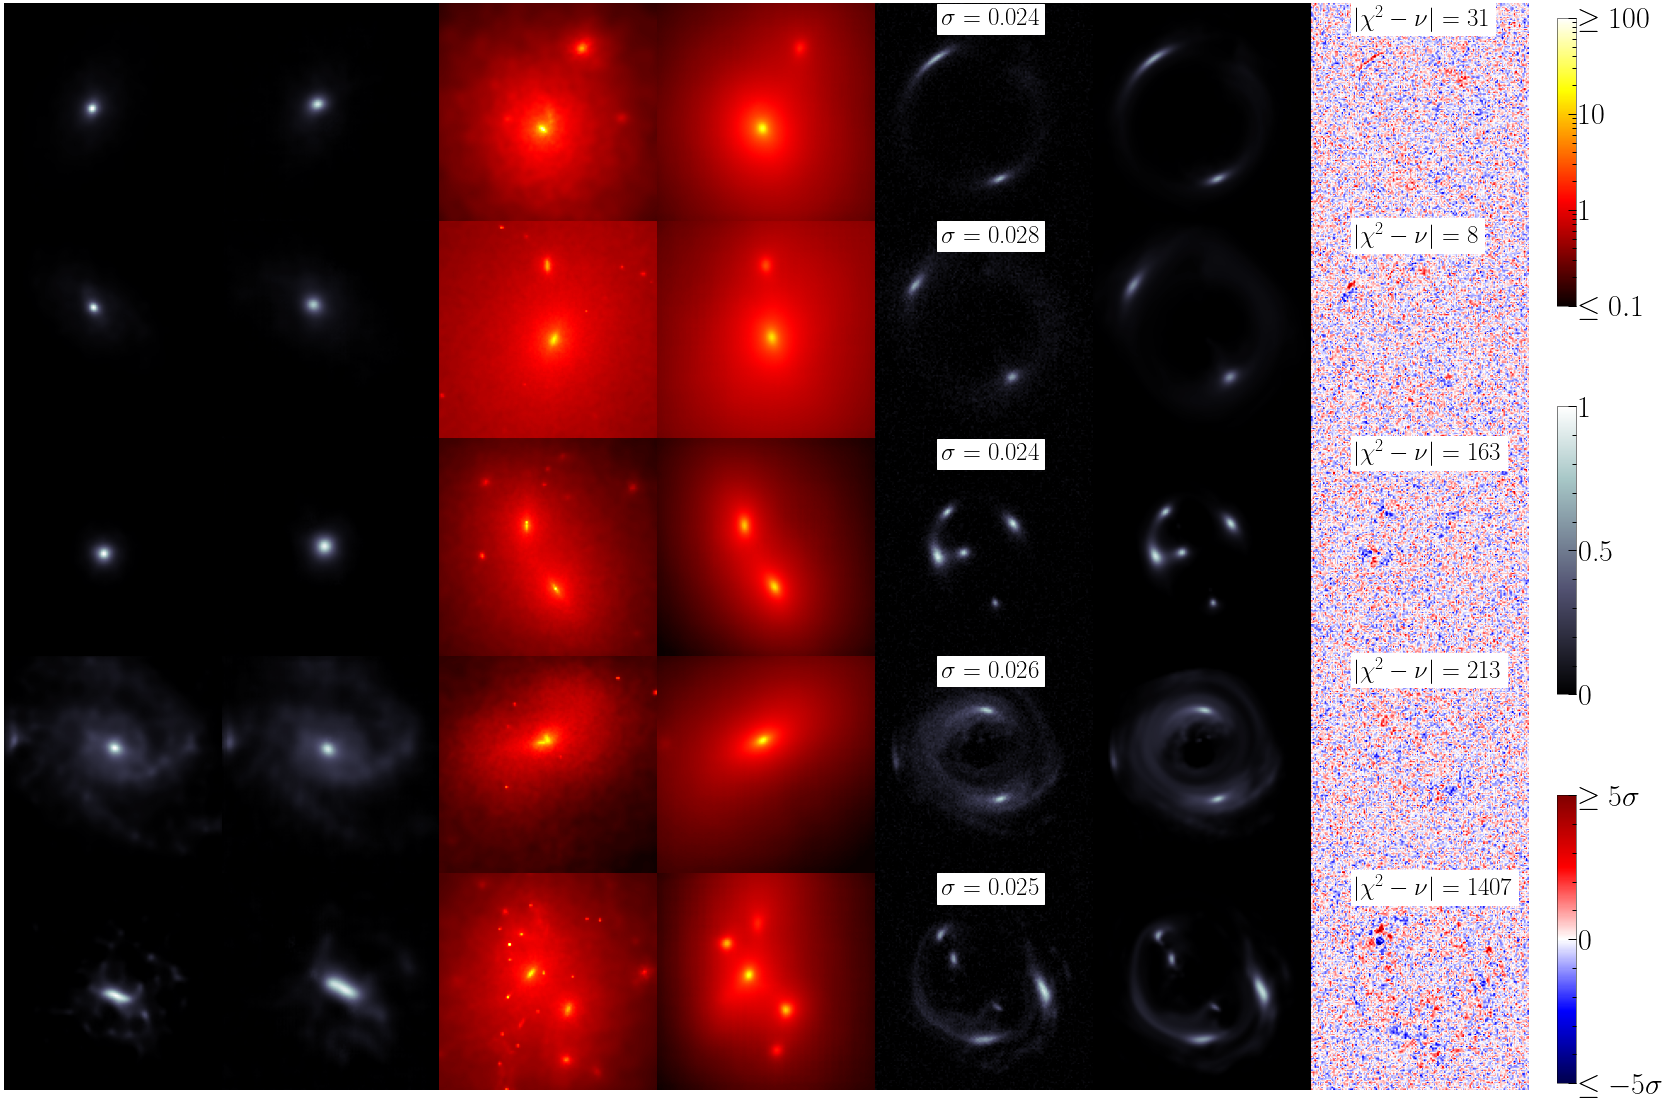

In [37]:
# order examples by their fine-tuend chi2
_indices = [70, 407, 1088, 1166,  2013] # cherry-picks

N = len(_indices)
fig, axs = plt.subplots(N, 7, figsize=(26, 4 * N))
start = 0

for i, ell in enumerate(_indices):
    j = indices[ell]
    lens = hf[f"observation"][j].squeeze()
    source = hf[f"source"][j].squeeze()
    kappa = hf[f"kappa"][j].squeeze()
    lens_pred = hf[f"observation_pred_reoptimized"][j].squeeze()
    source_pred = hf[f"source_pred_reoptimized"][j].squeeze()
    kappa_pred = hf[f"kappa_pred_reoptimized"][j].squeeze()
    chi_squared = hf["chi_squared_reoptimized"][j]
    noise_rms = hf["noise_rms"][j]
#     intensity_cmap = "twilight"
    intensity_cmap = "bone"
    a = 100
    i_min = 1e-2
#     i_norm = ImageNormalize(stretch=LogStretch(a), vmin=i_min, vmax=1)
    i_norm = ImageNormalize(vmin=0, vmax=1)

    axs[i, 0].imshow(source, cmap=intensity_cmap, norm=i_norm, origin="lower")
    axs[i, 1].imshow(source_pred, cmap=intensity_cmap, norm=i_norm, origin="lower")
    
    axs[i, 2].imshow(kappa, cmap="hot", norm=LogNorm(vmin=1e-1, vmax=100), origin="lower")
    axs[i, 3].imshow(kappa_pred, cmap="hot", norm=LogNorm(vmin=1e-1, vmax=100), origin="lower")
    
    axs[i, 4].imshow(lens, cmap=intensity_cmap, norm=i_norm, origin="lower")
    axs[i, 4].annotate(fr"$\sigma =$ {noise_rms:.3f}", xy=(0.3, 0.9), xycoords="axes fraction", size=25, backgroundcolor="w")
    axs[i, 5].imshow(lens_pred, cmap=intensity_cmap, norm=i_norm, origin="lower")
    residual = (lens - lens_pred)/noise_rms
    axs[i, 6].imshow(residual, cmap="seismic", vmin=-5, vmax=5, origin="lower")
    
    axs[i, 6].annotate(fr"$|\chi^2 - \nu| =$ {np.abs(chi_squared*128**2 - 128**2):.0f}", xy=(0.2, 0.9), xycoords="axes fraction", size=25, backgroundcolor="w")


    
for i in range(N):            
    for j in range(7):
        axs[i, j].axis("off")

fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.96, 0.67, 0.01, 0.2])
fig.colorbar(ScalarMappable(cmap="hot", norm=LogNorm(vmin=1e-1, vmax=100)), cax=cbar_ax, ticks=[0.1, 1, 10, 100])
cbar_ax.set_yticklabels(["$\leq 0.1$", "1", "10", "$\geq 100$"], fontsize=30) 
# cbar_ax.set_ylabel(r"Convergence", rotation=270, labelpad=50, fontsize=40)
cbar_ax.yaxis.set_label_position("right")


fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.96, 0.33 + .07, 0.01, 0.2])
fig.colorbar(ScalarMappable(cmap=intensity_cmap, norm=i_norm), cax=cbar_ax, ticks=[0, 0.5, 1])
# fig.colorbar(ScalarMappable(cmap=intensity_cmap, norm=LogNorm(vmin=1e-2, vmax=1)), cax=cbar_ax, ticks=[0.01, 0.1, 1.])
cbar_ax.set_yticklabels(["0", "0.5", "1"], fontsize=30)
# cbar_ax.set_yticklabels(["$\leq 0.01$", "0.1", "1"], fontsize=30) 
# cbar_ax.set_ylabel(r"Intensity", rotation=270, labelpad=100, fontsize=40)
cbar_ax.yaxis.set_label_position("right")

fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.96, 0.13, 0.01, 0.2])
fig.colorbar(ScalarMappable(cmap="seismic", norm=Normalize(vmin=-5, vmax=5)), cax=cbar_ax, ticks=[-5, 0, 5])
cbar_ax.set_yticklabels(["$\leq -5\sigma$",  "0",  "$\geq 5\sigma$"], fontsize=30) 
# cbar_ax.set_ylabel(r"Residuals", rotation=270, labelpad=60, fontsize=40)
cbar_ax.yaxis.set_label_position("right")


# axs[0, 0].set_title(r"$\mathbf{s}$", pad=20, fontsize=40)
# axs[0, 1].set_title(r"$\mathbf{\hat{s}}^{(T)}$", pad=20, fontsize=40)
# axs[0, 2].set_title("$\kappa$", pad=20, fontsize=40)
# axs[0, 3].set_title("$\hat{\kappa}^{(T)}$", pad=20, fontsize=40)
# axs[0, 4].set_title("$\mathbf{y}$", pad=20, fontsize=40)
# axs[0, 5].set_title("$\mathbf{\hat{y}}^{(T)}$", pad=20, fontsize=40)
# axs[0, 6].set_title("$(\mathbf{y} - \mathbf{\hat{y}}^{(T)})/\sigma$", pad=20, fontsize=40)
plt.subplots_adjust(wspace=-0.08, hspace=0)
plt.savefig("../figures/poster_results.png")

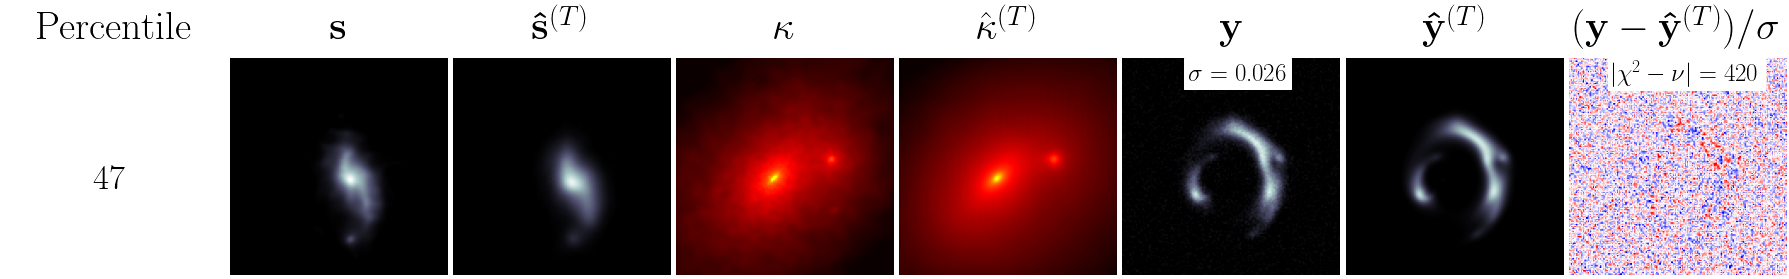

In [3]:
ell = 1396
fig, axs = plt.subplots(1, 8, figsize=(32, 4))
start = 0

j = indices[ell]
lens = hf[f"observation"][j].squeeze()
source = hf[f"source"][j].squeeze()
kappa = hf[f"kappa"][j].squeeze()
lens_pred = hf[f"observation_pred_reoptimized"][j].squeeze()
source_pred = hf[f"source_pred_reoptimized"][j].squeeze()
kappa_pred = hf[f"kappa_pred_reoptimized"][j].squeeze()
chi_squared = hf["chi_squared_reoptimized"][j]
noise_rms = hf["noise_rms"][j]
intensity_cmap = "bone"

i_norm = ImageNormalize(vmin=0, vmax=1)

axs[1].imshow(source, cmap=intensity_cmap, norm=i_norm, origin="lower")
axs[2].imshow(source_pred, cmap=intensity_cmap, norm=i_norm, origin="lower")

axs[3].imshow(kappa, cmap="hot", norm=LogNorm(vmin=1e-1, vmax=100), origin="lower")
axs[4].imshow(kappa_pred, cmap="hot", norm=LogNorm(vmin=1e-1, vmax=100), origin="lower")

axs[5].imshow(lens, cmap=intensity_cmap, norm=i_norm, origin="lower")
axs[5].annotate(fr"$\sigma =$ {noise_rms:.3f}", xy=(0.3, 0.9), xycoords="axes fraction", size=25, backgroundcolor="w")
axs[6].imshow(lens_pred, cmap=intensity_cmap, norm=i_norm, origin="lower")
residual = (lens - lens_pred)/noise_rms
axs[7].imshow(residual, cmap="seismic", vmin=-5, vmax=5, origin="lower")

axs[7].annotate(fr"$|\chi^2 - \nu| =$ {np.abs(chi_squared*128**2 - 128**2):.0f}", xy=(0.2, 0.9), xycoords="axes fraction", size=25, backgroundcolor="w")
axs[0].annotate(fr"{ell/len(indices) * 100:.0f}", xy=(0.4, 0.4), xycoords="axes fraction", size=35)

for j in range(8):
    axs[j].axis("off")

axs[0].set_title(r"Percentile", pad=20, fontsize=40)
axs[1].set_title(r"$\mathbf{s}$", pad=20, fontsize=40)
axs[2].set_title(r"$\mathbf{\hat{s}}^{(T)}$", pad=20, fontsize=40)
axs[3].set_title("$\kappa$", pad=20, fontsize=40)
axs[4].set_title("$\hat{\kappa}^{(T)}$", pad=20, fontsize=40)
axs[5].set_title("$\mathbf{y}$", pad=20, fontsize=40)
axs[6].set_title("$\mathbf{\hat{y}}^{(T)}$", pad=20, fontsize=40)
axs[7].set_title("$(\mathbf{y} - \mathbf{\hat{y}}^{(T)})/\sigma$", pad=20, fontsize=40)
plt.subplots_adjust(wspace=0, hspace=-0.1)

In [5]:
# _indices = [70, 407, 592, 805, 1088, 1166,  1527, 2013, 2041, 2562, 2851]
# highlight = 1396

# ell = 805
ell = 1088
start = 0
i_norm = ImageNormalize(vmin=0, vmax=1)

j = indices[ell]
lens = hf[f"observation"][j].squeeze()
source = hf[f"source"][j].squeeze()
kappa = hf[f"kappa"][j].squeeze()
lens_pred = hf[f"observation_pred_reoptimized"][j].squeeze()
source_pred = hf[f"source_pred_reoptimized"][j].squeeze()
kappa_pred = hf[f"kappa_pred_reoptimized"][j].squeeze()
chi_squared = hf["chi_squared_reoptimized"][j]
noise_rms = hf["noise_rms"][j]
intensity_cmap = "bone"

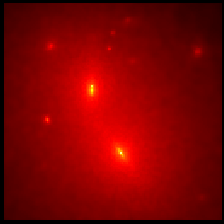

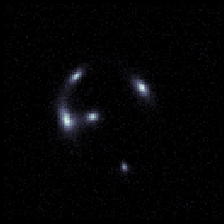

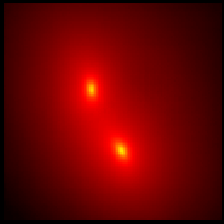

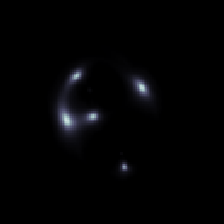

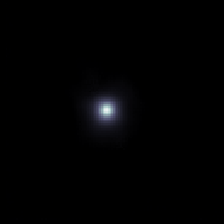

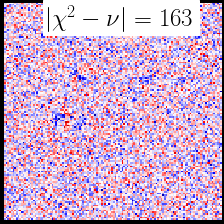

In [11]:
plt.style.use("dark_background")
plt.imshow(kappa, cmap="hot", norm=LogNorm(vmin=1e-1, vmax=100), origin="lower")
plt.axis("off")
plt.savefig(f"kappa_{ell}.png", facecolor="w")

plt.figure()
plt.imshow(lens, cmap=intensity_cmap, norm=i_norm, origin="lower")
plt.axis("off")
plt.savefig(f"obs_{ell}.png", facecolor="w")

plt.figure()
plt.imshow(source, cmap=intensity_cmap, norm=i_norm, origin="lower")
plt.axis("off")
plt.savefig(f"source_{ell}.png", facecolor="w")

plt.imshow(kappa_pred, cmap="hot", norm=LogNorm(vmin=1e-1, vmax=100), origin="lower")
plt.axis("off")
plt.savefig(f"kappa_ft_{ell}.png", facecolor="w")

plt.figure()
plt.imshow(lens_pred, cmap=intensity_cmap, norm=i_norm, origin="lower")
plt.axis("off")
plt.savefig(f"obs_ft_{ell}.png", facecolor="w")

plt.figure()
plt.imshow(source_pred, cmap=intensity_cmap, norm=i_norm, origin="lower")
plt.axis("off")
plt.savefig(f"source_ft_{ell}.png", facecolor="w")

plt.figure()
plt.annotate(fr"$|\chi^2 - \nu| =$ {np.abs(chi_squared*128**2 - 128**2):.0f}", xy=(0.2, 0.9), xycoords="axes fraction", size=25, backgroundcolor="w", color="k")
plt.imshow((lens - lens_pred) / noise_rms, cmap="seismic", vmax=5, vmin=-5, origin="lower")
plt.axis("off")
plt.savefig(f"residual_ft_{ell}.png", facecolor="w")


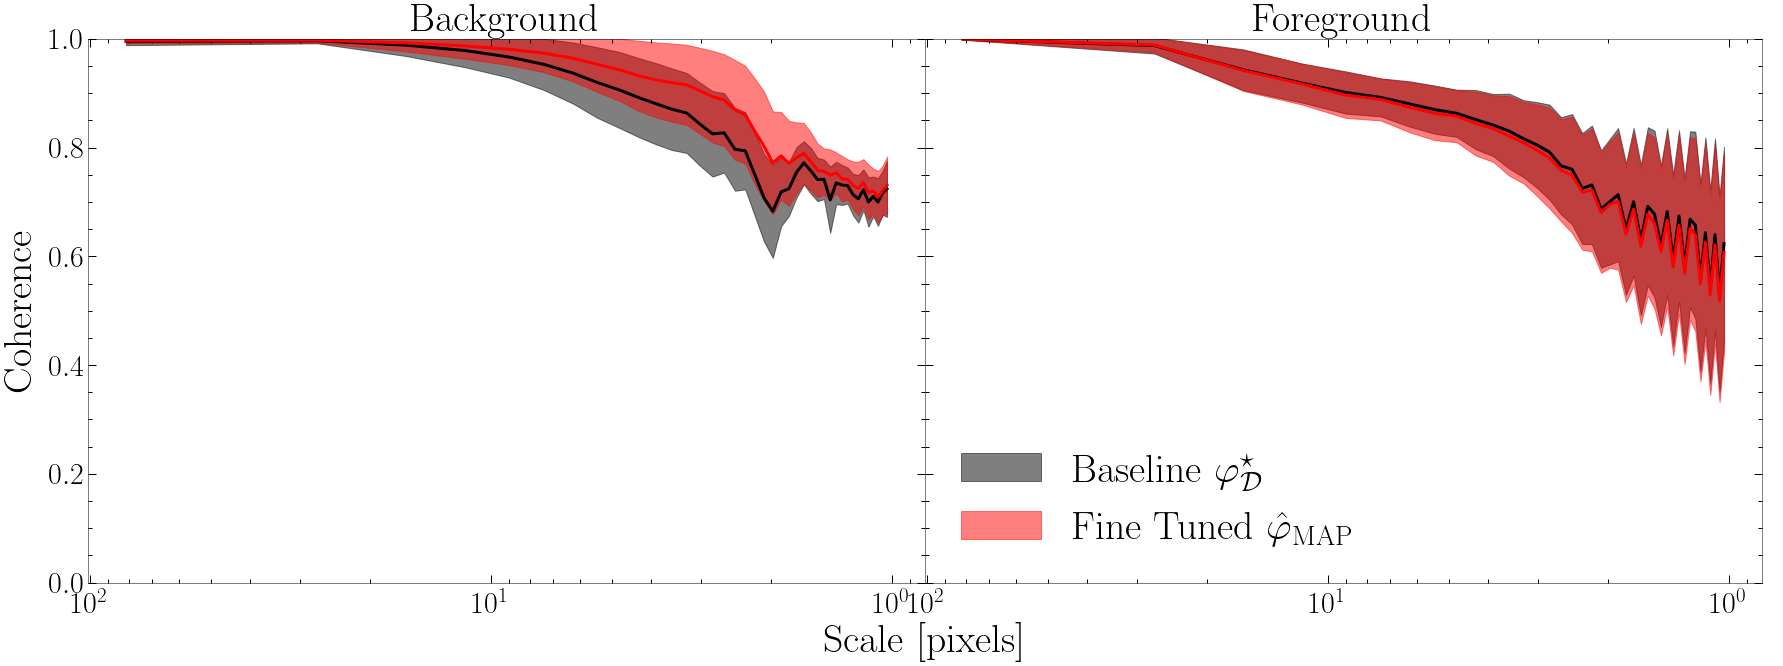

In [28]:
fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(30, 10), sharey=True)
color = "k"
color2 = "r"

f = np.array(hf["observation_frequencies"])

# kappa
gamma_ro = hf["kappa_coherence_spectrum_reoptimized"][:]
gamma = hf["kappa_coherence_spectrum"][:]
bins=gamma.shape[1]

gamma_mean = gamma.mean(axis=0)
gamma_std = gamma.std(axis=0)
gamma_ro_mean = gamma_ro.mean(axis=0)
gamma_ro_std = gamma_ro.std(axis=0)
lam = 1/f/2 # scale

ax1.plot(lam, gamma_mean, "-", color=color, lw=3)
ax1.fill_between(lam, gamma_mean - gamma_std, gamma_mean + gamma_std, color=color, alpha=0.5, label=r"Baseline $\varphi_{\mathcal{D}}^{\star}$")
ax1.plot(lam, gamma_ro_mean, "-", color=color2, lw=3)
ax1.fill_between(lam, gamma_ro_mean - gamma_ro_std, gamma_ro_mean + gamma_ro_std, color=color2, alpha=0.5, label=r"Fine Tuned $\hat{\varphi}_{\mathrm{MAP}}$")
ax1.invert_xaxis()
ax1.set_xscale("log")
ax1.set_ylim(0, 1)
ax1.set_title("Foreground", fontsize=40)
ax1.legend(loc="lower left", fontsize=40)
ax1.tick_params(axis='x', pad=10)


# source
gamma_ro = hf["source_coherence_spectrum_reoptimized"][:]
gamma = hf["source_coherence_spectrum"][:]
bins=gamma.shape[1]

gamma_mean = gamma.mean(axis=0)
gamma_std = gamma.std(axis=0)
gamma_ro_mean = gamma_ro.mean(axis=0)
gamma_ro_std = gamma_ro.std(axis=0)
lam = 1/f/2 # scale

ax2.plot(lam, gamma_mean, "-", color=color, lw=3)
ax2.fill_between(lam, gamma_mean - gamma_std, gamma_mean + gamma_std, color=color, alpha=0.5)
ax2.plot(lam, gamma_ro_mean, "-", color=color2, lw=3)
ax2.fill_between(lam, gamma_ro_mean - gamma_ro_std, gamma_ro_mean + gamma_ro_std, color=color2, alpha=0.5)
ax2.invert_xaxis()
ax2.set_xscale("log")
ax2.set_title("Background", fontsize=40)
ax2.tick_params(axis='x', pad=10)
ax2.set_ylabel(r"Coherence", labelpad=10, fontsize=40)


fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel(r"Scale [pixels]", labelpad=10, fontsize=40)

plt.subplots_adjust(wspace=0, hspace=0);
plt.savefig("../figures/coherence_spectrum", facecolor="w")

In [11]:
from censai import AnalyticalPhysicalModel
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.pylab as pylab

plt.style.use("science") # requires SciencePlots
params = {'legend.fontsize': 27,
          'figure.figsize': (4, 4),
         'axes.labelsize': 27,
         'axes.titlesize': 30,
         'xtick.labelsize':30,
         'ytick.labelsize':30,
         'figure.titlesize': 40,
          'xtick.major.size': 8,
          'xtick.minor.size': 4,
         'xtick.major.width': 1,
          'xtick.minor.width': 1,
         'ytick.major.size': 8,
          'ytick.minor.size': 4,
         'ytick.major.width': 1,
          'ytick.minor.width': 1,

         }
pylab.rcParams.update(params)

In [12]:
phys = AnalyticalPhysicalModel()

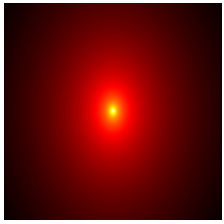

In [13]:
plt.imshow(phys.kappa_field(e=0.3)[0, ..., 0], cmap="hot", norm=LogNorm())
plt.axis("off")
plt.savefig("sie.png")